In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
BATCH_SIZE = 2

IMG_SIZE = 512

NUM_CLASSES = 5

NUM_TRAIN_IMAGES = 7470

NUM_VAL_IMAGES = 1602

# Load data

In [3]:
abs_path = %pwd

In [4]:
slash_idx = [idx for idx,ch in enumerate(abs_path) if ch=='/']

abs_path = abs_path[:slash_idx[-2]]

In [5]:
DATA_DIR = abs_path + '/data/processed'

DATA_DIR

'/home/marcin/git_workspace/roads_semantic_segmentation_in_LandCover.ai_dataset/data/processed'

In [6]:
TRAIN_PATH = DATA_DIR + '/train'
VAL_PATH = DATA_DIR + '/val'
TEST_PATH = DATA_DIR + '/test'

In [7]:
train_images = sorted(glob(os.path.join(TRAIN_PATH, "images/img/*")))
train_masks = sorted(glob(os.path.join(TRAIN_PATH, "masks/img/*")))
val_images = sorted(glob(os.path.join(VAL_PATH, "images/img/*")))
val_masks = sorted(glob(os.path.join(VAL_PATH, "masks/img/*")))
test_images = sorted(glob(os.path.join(TEST_PATH, "images/img/*")))
test_masks = sorted(glob(os.path.join(TEST_PATH, "masks/img/*")))


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=3)
        image = image[..., 0]
        image = tf.reshape(image, (IMG_SIZE, IMG_SIZE, 1))
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])
    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])
        image = image / 127.5 - 1
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)
test_dataset = data_generator(test_images, val_images)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)
print("Test Dataset:", test_dataset)


Train Dataset: <BatchDataset shapes: ((2, 512, 512, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>
Val Dataset: <BatchDataset shapes: ((2, 512, 512, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>
Test Dataset: <BatchDataset shapes: ((2, 512, 512, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>


## Implement DeepLabv3+ according to official TF demo

https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb

In [8]:
# import os
# from io import BytesIO
# import tarfile
# import tempfile
# from six.moves import urllib

# from matplotlib import gridspec
# from matplotlib import pyplot as plt
# import numpy as np
# from PIL import Image

# import tensorflow as tf

In [9]:
# class DeepLabModel(object):
#     """Class to load deeplab model and run inference."""

#     INPUT_TENSOR_NAME = 'ImageTensor:0'
#     OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
#     INPUT_SIZE = 513
#     FROZEN_GRAPH_NAME = 'frozen_inference_graph'

#     def __init__(self, tarball_path):
#         """Creates and loads pretrained deeplab model."""
#         self.graph = tf.Graph()

#         graph_def = None
#         # Extract frozen graph from tar archive.
#         tar_file = tarfile.open(tarball_path)
#         for tar_info in tar_file.getmembers():
#             if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
#                 file_handle = tar_file.extractfile(tar_info)
#                 graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
#                 break

#         tar_file.close()

#         if graph_def is None:
#             raise RuntimeError('Cannot find inference graph in tar archive.')

#         with self.graph.as_default():
#             tf.import_graph_def(graph_def, name='')

#         self.sess = tf.compat.v1.Session(graph=self.graph)

#     def run(self, image):
#         """Runs inference on a single image.

#         Args:
#           image: A PIL.Image object, raw input image.

#         Returns:
#           resized_image: RGB image resized from original input image.
#           seg_map: Segmentation map of `resized_image`.
#         """
#         width, height = image.size
#         resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
#         target_size = (int(resize_ratio * width), int(resize_ratio * height))
#         resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
#         batch_seg_map = self.sess.run(
#             self.OUTPUT_TENSOR_NAME,
#             feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
#         seg_map = batch_seg_map[0]
#         return resized_image, seg_map

In [10]:
# def create_pascal_label_colormap():
#     """Creates a label colormap used in PASCAL VOC segmentation benchmark.

#     Returns:
#     A Colormap for visualizing segmentation results.
#     """
#     colormap = np.zeros((256, 3), dtype=int)
#     ind = np.arange(256, dtype=int)

#     for shift in reversed(range(8)):
#         for channel in range(3):
#             colormap[:, channel] |= ((ind >> channel) & 1) << shift
#         ind >>= 3

#     return colormap


# def label_to_color_image(label):
#     """Adds color defined by the dataset colormap to the label.

#     Args:
#     label: A 2D array with integer type, storing the segmentation label.

#     Returns:
#     result: A 2D array with floating type. The element of the array
#       is the color indexed by the corresponding element in the input label
#       to the PASCAL color map.

#     Raises:
#     ValueError: If label is not of rank 2 or its value is larger than color
#       map maximum entry.
#     """
#     if label.ndim != 2:
#         raise ValueError('Expect 2-D input label')

#     colormap = create_pascal_label_colormap()

#     if np.max(label) >= len(colormap):
#         raise ValueError('label value too large.')

#     return colormap[label]

In [11]:
# def vis_segmentation(image, seg_map):
#     """Visualizes input image, segmentation map and overlay view."""
#     plt.figure(figsize=(15, 5))
#     grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

#     plt.subplot(grid_spec[0])
#     plt.imshow(image)
#     plt.axis('off')
#     plt.title('input image')

#     plt.subplot(grid_spec[1])
#     seg_image = label_to_color_image(seg_map).astype(np.uint8)
#     plt.imshow(seg_image)
#     plt.axis('off')
#     plt.title('segmentation map')

#     plt.subplot(grid_spec[2])
#     plt.imshow(image)
#     plt.imshow(seg_image, alpha=0.7)
#     plt.axis('off')
#     plt.title('segmentation overlay')

#     unique_labels = np.unique(seg_map)
#     ax = plt.subplot(grid_spec[3])
#     plt.imshow(
#         FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
#     ax.yaxis.tick_right()
#     plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
#     plt.xticks([], [])
#     ax.tick_params(width=0.0)
#     plt.grid('off')
#     plt.show()

# LABEL_NAMES = np.asarray([
# 'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
# 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
# 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
# ])


# #     LABEL_NAMES = np.asarray([
# #         'building', 'woodland', 'water', 'road', 'background'
# #     ])

# FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
# FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)


In [12]:
# MODEL_NAME = 'xception_coco_voctrainval'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

# _DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
# _MODEL_URLS = {
#     'mobilenetv2_coco_voctrainaug':
#         'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
#     'mobilenetv2_coco_voctrainval':
#         'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
#     'xception_coco_voctrainaug':
#         'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
#     'xception_coco_voctrainval':
#         'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
# }
# _TARBALL_NAME = 'deeplab_model.tar.gz'

# model_dir = tempfile.mkdtemp()
# tf.io.gfile.mkdir(model_dir)

# download_path = os.path.join(model_dir, _TARBALL_NAME)

In [13]:
# # run if not already downloaded

# print('downloading model, this might take a while...')
# urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
#                    download_path)
# print('download completed! loading DeepLab model...')

In [14]:
# MODEL = DeepLabModel(download_path)
# print('model loaded successfully!')

In [15]:
# SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
# IMAGE_URL = ''  #@param {type:"string"}

# _SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
#                'deeplab/g3doc/img/%s.jpg?raw=true')


# def run_visualization(url):
#     """Inferences DeepLab model and visualizes result."""
#     try:
#         f = urllib.request.urlopen(url)
#         jpeg_str = f.read()
#         original_im = Image.open(BytesIO(jpeg_str))
#     except IOError:
#         print('Cannot retrieve image. Please check url: ' + url)
#         return

#     print('running deeplab on image %s...' % url)
#     resized_im, seg_map = MODEL.run(original_im)

#     vis_segmentation(resized_im, seg_map)


# image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
# run_visualization(image_url)

In [16]:
# SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
# IMAGE_URL = ''  #@param {type:"string"}

# _SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
#                'deeplab/g3doc/img/%s.jpg?raw=true')


# def run_visualization(url):
#     """Inferences DeepLab model and visualizes result."""
#     try:
#         f = urllib.request.urlopen(url)
#         jpeg_str = f.read()
#         original_im = Image.open(BytesIO(jpeg_str))
#     except IOError:
#         print('Cannot retrieve image. Please check url: ' + url)
#         return

#     print('running deeplab on image %s...' % url)
#     resized_im, seg_map = MODEL.run(original_im)

#     vis_segmentation(resized_im, seg_map)


# image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
# run_visualization(image_url)

# Build DeepLabv3+ and load weights

https://keras.io/examples/vision/deeplabv3_plus/

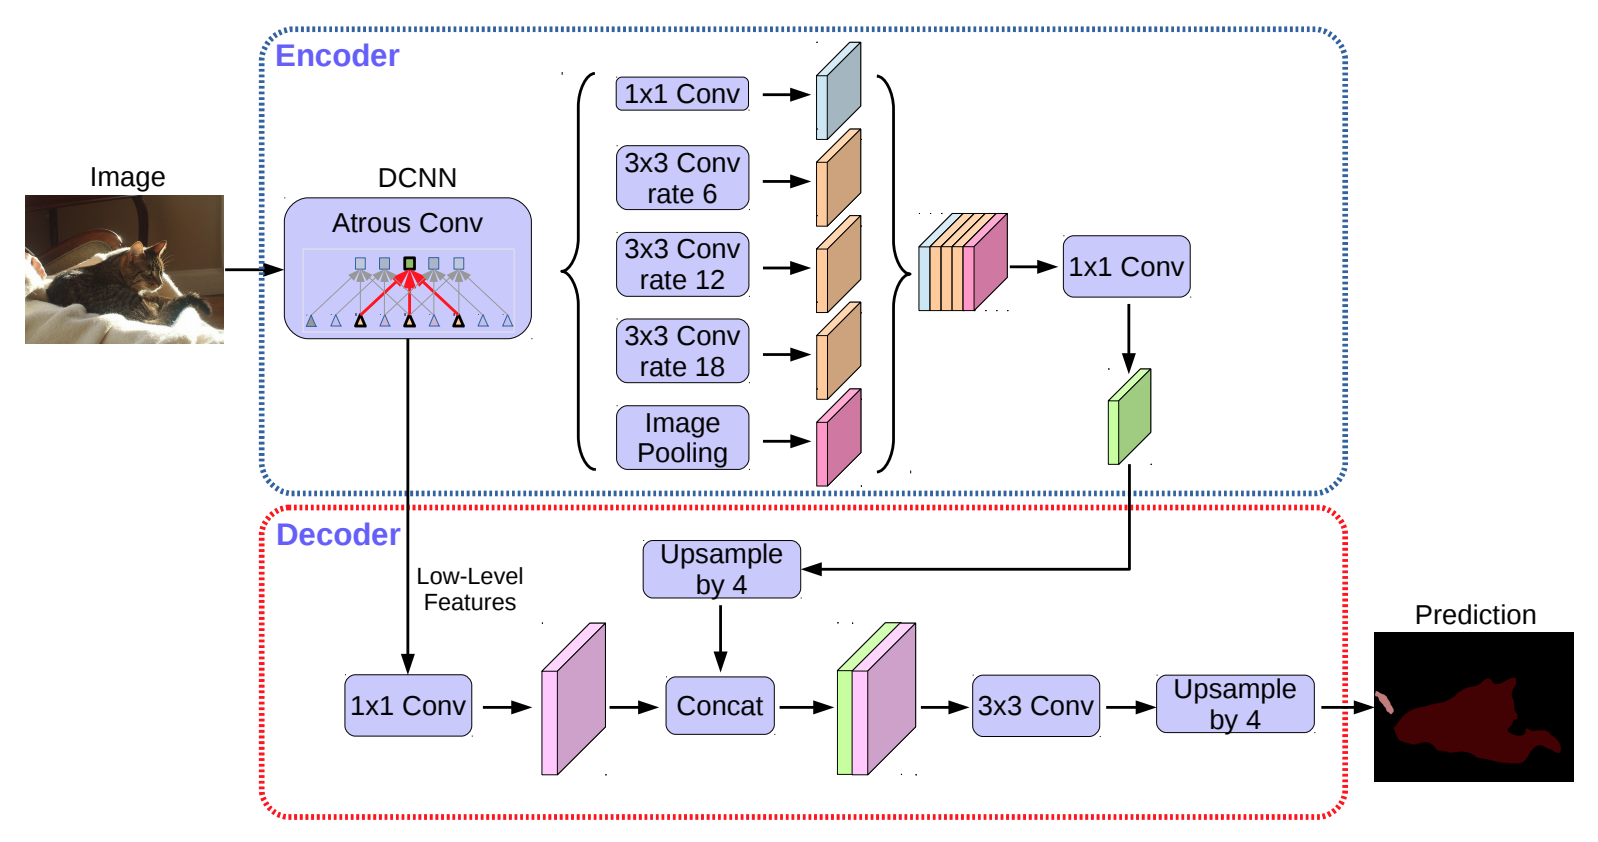

In [17]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [19]:
def DeeplabV3Plus(img_size, num_classes):
    model_input = tf.keras.Input(shape=(img_size, img_size, 3))
    resnet50 = tf.keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    
    resnet50.trainable = False
    
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(img_size // 4 // x.shape[1], img_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(img_size // x.shape[1], img_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return tf.keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(img_size=IMG_SIZE, num_classes=NUM_CLASSES)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [20]:
# callbacks

def get_best_weights_callback(filepath):
    
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor='val_accuracy', 
        verbose=1, 
        save_best_only=True,
        save_weights_only=True, 
        mode='max', 
        save_freq='epoch')

    return checkpoint_callback

In [21]:
checkpoint_path = abs_path + '/notebooks/exploratory/results/baseline_DeepLabv3+_not_augmented/best/best_weights'

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

In [22]:
early_stopping_val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

best_val_acc = get_best_weights_callback(checkpoint_path)

Epoch 1/15
3735/3735 [==============================] - 415s 110ms/step - loss: 0.7235 - accuracy: 0.7097 - val_loss: 2.4463 - val_accuracy: 0.3161

Epoch 00001: val_accuracy improved from -inf to 0.31613, saving model to /home/marcin/git_workspace/roads_semantic_segmentation_in_LandCover.ai_dataset/notebooks/exploratory/results/baseline_DeepLabv3+_not_augmented/best/best_weights
Epoch 2/15
3735/3735 [==============================] - 397s 106ms/step - loss: 0.6210 - accuracy: 0.7625 - val_loss: 1.2870 - val_accuracy: 0.5282

Epoch 00002: val_accuracy improved from 0.31613 to 0.52820, saving model to /home/marcin/git_workspace/roads_semantic_segmentation_in_LandCover.ai_dataset/notebooks/exploratory/results/baseline_DeepLabv3+_not_augmented/best/best_weights
Epoch 3/15
3735/3735 [==============================] - 404s 108ms/step - loss: 0.5495 - accuracy: 0.7957 - val_loss: 0.8551 - val_accuracy: 0.6897

Epoch 00003: val_accuracy improved from 0.52820 to 0.68975, saving model to /home/

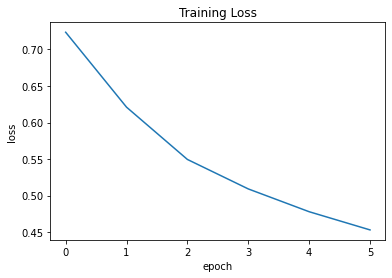

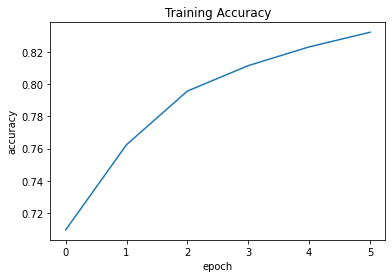

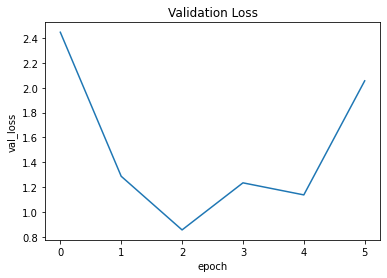

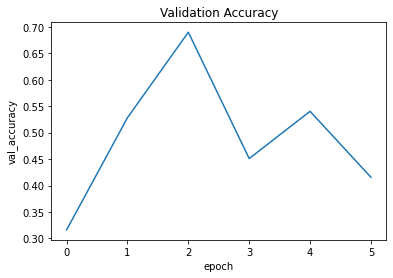

In [23]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, 
                    validation_data=val_dataset, 
                    epochs=15,
                   callbacks=[early_stopping_val_loss,
                             best_val_acc])

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()


In [31]:
model.load_weights(checkpoint_path)

In [32]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l][0]
        g[idx] = colormap[l][1]
        b[idx] = colormap[l][2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, NUM_CLASSES)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )


In [33]:
colormap = [[0, 0, 0], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 255]]

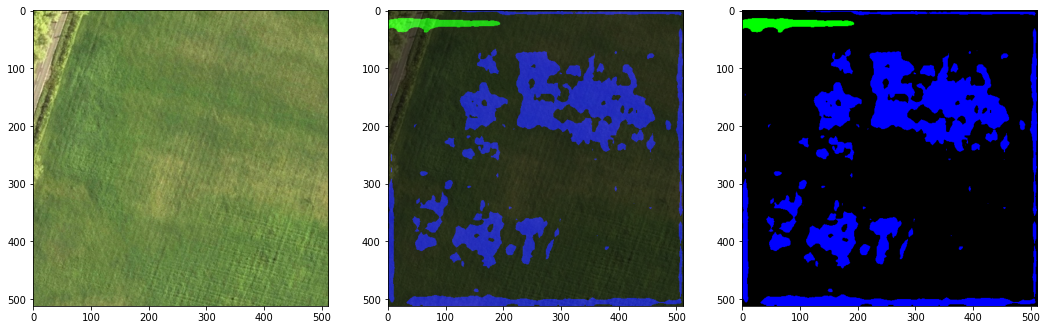

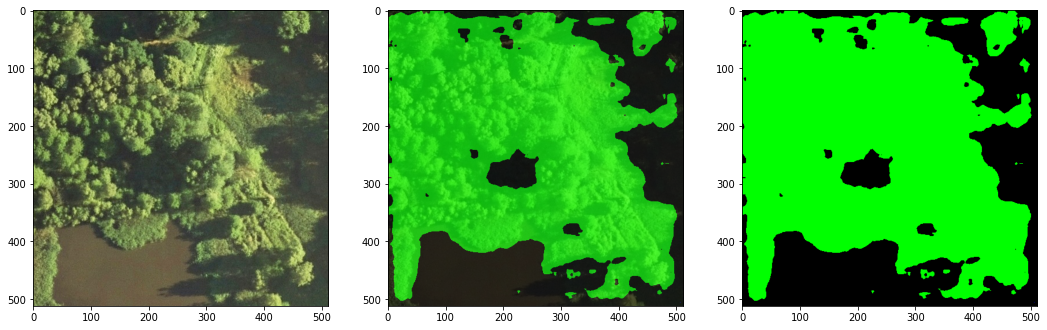

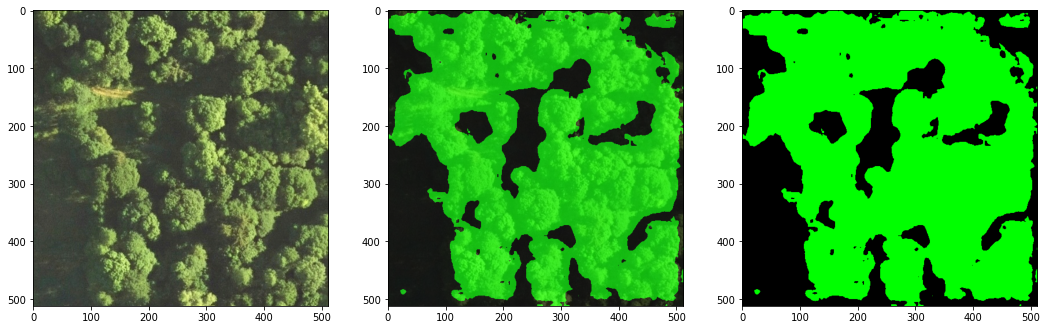

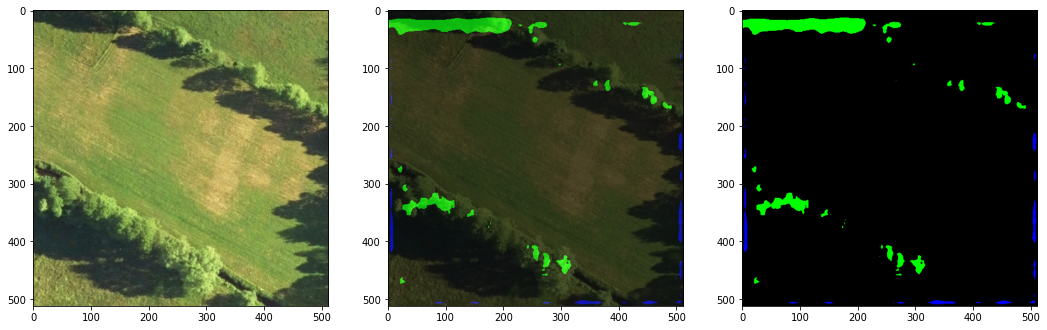

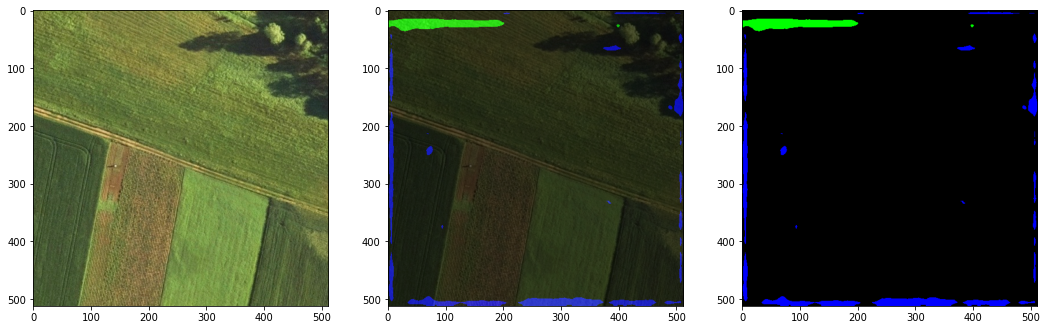

In [36]:
plot_predictions(test_images[50:55], colormap, model=model)